<a href="https://colab.research.google.com/github/liorot/IDC_NLP_Final_Project_2022/blob/main/BertModelAndAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the main notebook of the project. here we:
1. Trained the Bert model
2. Analyze the dating application data with the results of the personality classifier

In [1]:
!pip install transformers --quiet
!pip install pytorch_lightning==1.6.5 --quiet
!pip install html2text --quiet

     |████████████████████████████████| 4.7 MB 3.8 MB/s 
     |████████████████████████████████| 101 kB 12.0 MB/s 
     |████████████████████████████████| 6.6 MB 63.7 MB/s 
     |████████████████████████████████| 596 kB 73.2 MB/s 
     |████████████████████████████████| 585 kB 4.2 MB/s 
     |████████████████████████████████| 419 kB 87.1 MB/s 
     |████████████████████████████████| 141 kB 81.7 MB/s 


In [2]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from html2text import html2text

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import auc, roc_curve

from transformers import BertTokenizerFast as BertTokenizer, BertModel, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy, auroc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# Data
## Read data

In [16]:
drive.mount('/drive')
DIRECTORY = '/drive/MyDrive/Colab Notebooks/NLPFinalProject/mbti.csv'
PATH = '/drive/MyDrive/Colab Notebooks/bert_trained_model.pt'
data = pd.read_csv(DIRECTORY)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## Analyze Data

In [6]:
pd.set_option('max_colwidth', 500)
data.sample(3)

,type,posts
4042,ENFP,"'Sometimes I'll think really mean things about myself and I think gosh, if I acted the same way towards a friend as I do towards myself I'd be a really awful friend. I think part of healing is...|||You know it's funny I figured out my subtypes a while back when I was maybe not so self aware, but this thread made me go back and look through it all again and it turns out sp/so does seem...|||I feel like my fixes have different instincts, but that's only based off subtype descriptions (Naranjo ..."
7200,INTP,"'Can't draw, but there's this... https://www.youtube.com/watch?v=BIO1BqxRYDo|||Isn't it obvious? it's the same reason every INTP enters a room and immediately sits in the corner. observation, protection, and camoflauge|||Growing up in a hell-hole filled with drug addicts and having zero friends for 18 years, then getting to college on a full ride and within a month being the happiest you've ever been?|||Been a while. College is.......heaven. I wrote this. then promptly killed anyone tha..."
4461,ENFP,"'Guys how do you attach a picture on here?! gosh i feel like my parents just now .... P.s: KiRrRr you are gorgeous!! so is your natural habitat :))|||100% Respect :cheers2: , i sought marijuana in college, really wanted to try it, totally not worth it|||I've edited the inital post.. do let us know why, is it values and a moral issue, awareness and education, lack of interest etc... Optimist Mind, done !|||Thanks that was quite uplifting... and true! :rockon:|||Apparently doesn't do so wel..."


### What is MBTI
MBTI is a personality Myers Briggs Type Indicator is a personality type system that divides personalities into 16 distinct types across 4 axis:


* Introversion (I) – Extroversion (E)
* Intuition (N) – Sensing (S)
* Thinking (T) – Feeling (F)
* Judging (J) – Perceiving (P)

Where each person will have a personality abbreviated from the combination of all 4 axis i.e. someone who is introverted, relies more on intuitions, feeling, and perceive rather than judge will be be labelled as an INFP. The combinations of all these axis creates a more complex traits, strengths, and weaknesses.

we modeled personality detection on the MBTI dataset as a multilabel classification task.

In particular, the model treats each personality axis as a separate class, computing an independent probability for each one of them .

In [7]:
LABEL_COLUMNS = ["I-E","N-S","T-F","J-P"]
classes = {"I":0, "E":1, # axis 1
           "N":0,"S":1, # axis 2
           "T":0, "F":1, # axis 3
           "J":0,"P":1} # axis 4
PERSONALTIES_TYPE = {x:i for i,x in enumerate(set(data['type'].to_list()))}
data['label'] = data['type'].apply(lambda x: PERSONALTIES_TYPE[x])

### Data distribution

[Text(0.5, 1.0, 'Distribution of Personality Types in the Data')]

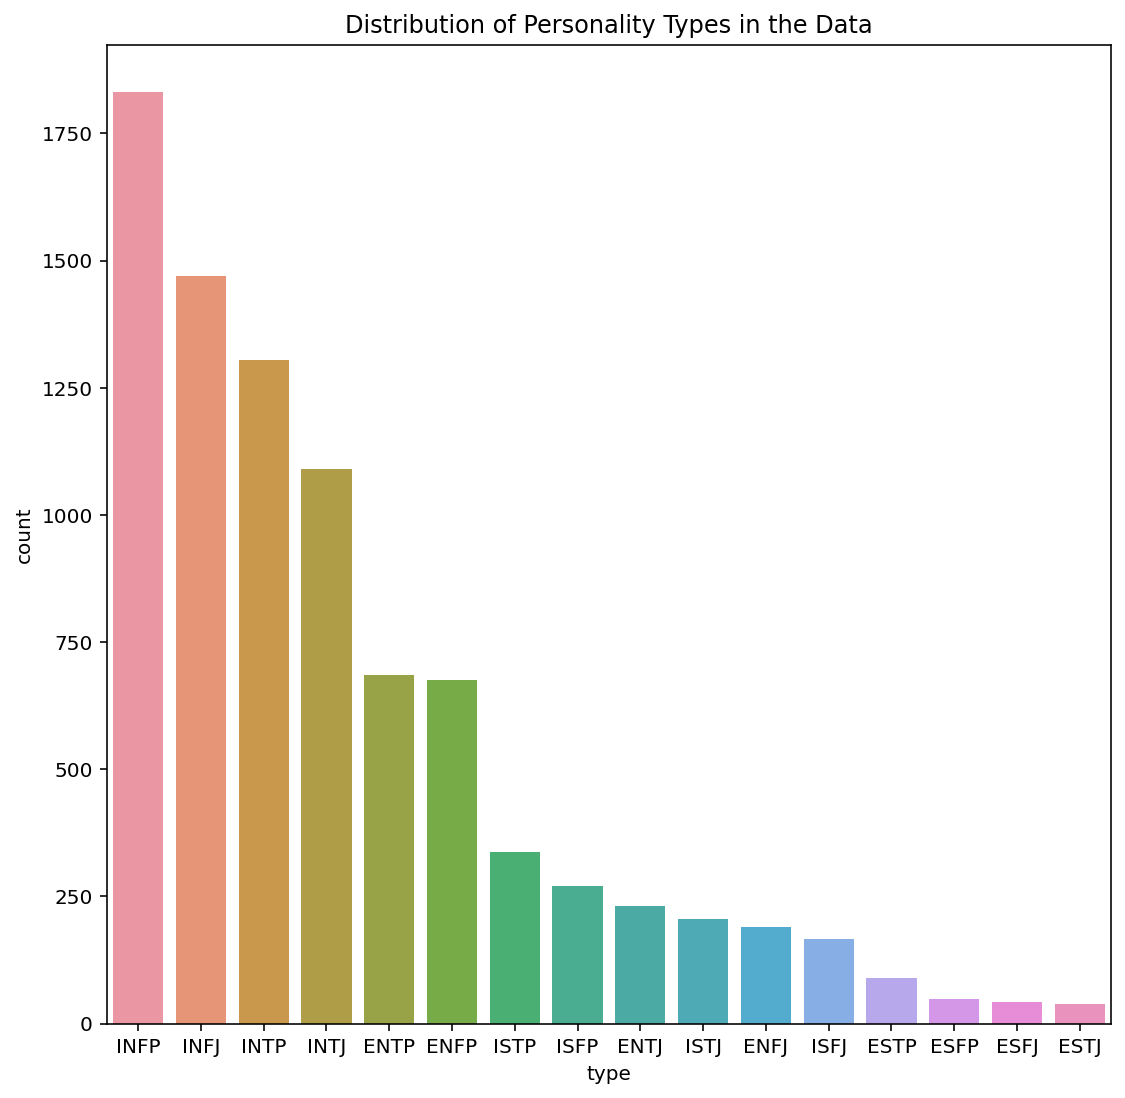

In [ ]:
plt.figure(figsize=(9, 9))
sns.countplot(data=data,x='type', order = data['type'].value_counts().index).set(title='Distribution of Personality Types in the Data')

## Preprocessing
The following operation are performed: text lowercasing, removing text in square brackets, links, words containing numbers, emoji

In [8]:
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

# method to clean the text
def clean_post(text, drop_stop_words = True, drop_per_types=True):
    text = text.lower()
    # replacing ||| with space
    text = re.sub(r"\|\|\|", " ", text)

    text = re.sub('https?://\S+|www\.\S+', '', text) # remove url
    # this function remove emoji 
    text.encode('ascii', 'ignore').decode('ascii')

    # remove extra white spaces
    text = remove_extra_white_spaces(text)
    
    # tokenize the text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    if drop_per_types:
        text = [x for x in text if x.upper() not in PERSONALTIES_TYPE]
        
    if drop_stop_words:
        for word in stopwords.words('english'):
            if word in text:
                text.remove(word) 

    # remove empty/1 length words
    text = [t for t in text if len(t) > 1]
    
    # lemmatize
    clean_post = lemmatizing(" ".join(text))

    return clean_post

In [ ]:
# clean the data
data['posts'] = data['posts'].apply(clean_post)

## split to train-test-validation

In [ ]:
# Split to train test and val
train_df, test_df = train_test_split(data, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.1)
print (f" train data size is: {train_df.shape}")
print (f" test data size is: {test_df.shape}")
print (f" val data size is: {val_df.shape}")

 train data size is: (6246, 3)
 test data size is: (1735, 3)
 val data size is: (694, 3)


## Dataset

## Tokenize Dataset

In [9]:
from transformers import BertTokenizer
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

When using Bert before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.
We need to specify the maximum number of tokens when encoding (512 is the maximum we can do)

The below cell will perform one tokenization pass of the dataset in order to measure the maximum post length
You can see counts in the graph below:

Text(0.5, 1.0, 'Count of Tokens Per Post')

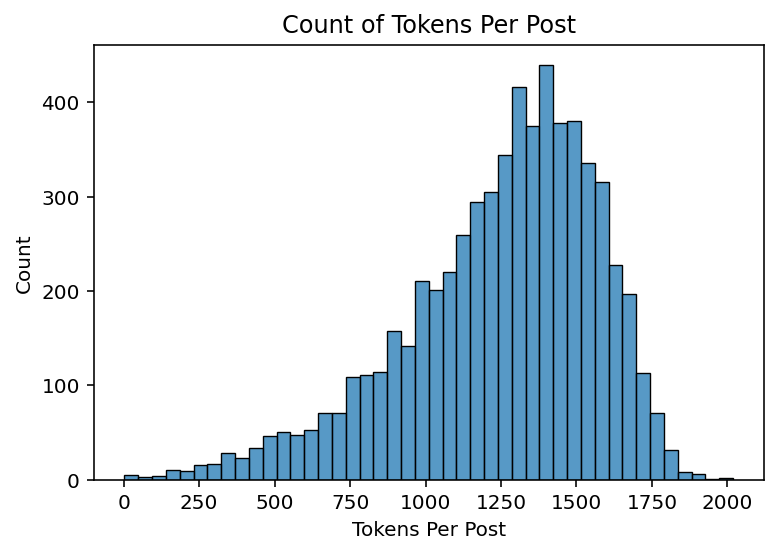

In [ ]:
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["posts"],
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlabel('Tokens Per Post')
plt.title("Count of Tokens Per Post")

We can see that most of the posts contain more than 512. So, we’ll stick with the limit of 512.

## Create custom pytorch MBTITweetsDataset
We'll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors and cleaning the data using the function we first built

In [10]:
class MBTITweetsDataset(Dataset):
  """
  In this class, we'll transform our dataset into the format that BERT can be trained on.
  To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

  """
  def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 512):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    post_text = data_row.posts
    labels = self.get_labels(data_row)

    # bert tokenizion
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start and the `[SEP]` token to the end.
    #   (3) Map tokens to their IDs.
    #   (4) Pad or truncate the sentence to `max_length`
    #   (5) Create attention masks for [PAD] tokens.

    encoding = self.tokenizer.encode_plus(
      post_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      post_text=post_text,
      mbti_type=data_row['type'],
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )
  
  def get_labels(self, row):
    labels = [classes[p] for p in row["type"]]
    return np.array(labels, dtype="float32")

## Create custom Data Loader - MBTITweetsDataModule
will warp in this class an iterator for our datasets using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.
it will encapsulates all data loading logic and returns the necessary data loaders. 

In [11]:
#We’ll wrap our custom dataset into a LightningDataModule

class MBTITweetsDataModule(pl.LightningDataModule):

  def __init__(self, train_df, val_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
    self.random_sampler = self.get_train_sampler()

  def setup(self, stage=None):
    self.train_dataset = MBTITweetsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.val_dataset = MBTITweetsDataset(
    self.val_df,
    self.tokenizer,
    self.max_token_len
    )

  # Use to balance the data
  def get_train_sampler(self):
    labels=self.train_df['label']
    counts = np.bincount(labels)
    labels_weights = 1. / counts
    weights = labels_weights[labels]
    return WeightedRandomSampler(weights, len(weights))

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      sampler=self.random_sampler,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

## Train learning constants

In [ ]:
MAX_TOKEN_COUNT = 512
N_EPOCHS = 10
BATCH_SIZE = 12
LEARNING_RATE = 2e-5

data_module = MBTITweetsDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

# Bert Model
Our model will use a pre-trained BertModel and a linear layer to convert the BERT representation to a classification task. We’ll pack everything in a LightningModule


In [13]:
class MBTIPersonalityTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):
    """
    The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model.
    """

    optimizer = torch.optim.AdamW(self.parameters(), lr=LEARNING_RATE)
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

## Train model

In [ ]:
"""
To use the scheduler, we need to calculate the number of training and warm-up steps. 
The number of training steps per epoch is equal to number of training examples / batch size. 
The number of total training steps is training steps per epoch * number of epochs:
"""
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1040, 5200)

In [ ]:
model = MBTIPersonalityTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="tweets_mbti")
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fa2a94d2d50>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fa2a94d2d50>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

In [ ]:
torch.cuda.empty_cache()

In [ ]:
trainer.fit(model, data_module)

Missing logger folder: lightning_logs/tweets_mbti
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | classifier | Linear    | 3.1 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.941   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Save Model
saving the best trained model

In [ ]:
trained_model = MBTIPersonalityTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
# save the model
torch.save(trained_model, PATH)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Model Evaluation

In [14]:
THRESHOLD = 0.5
MAP = [{0:"I", 1:"E"}, # axis 1
{0:"N",1:"S"}, # axis 2
{0:"T", 1:"F"}, # axis 3
{0:"J",1:"P"}] # axis 4

def create_mbti_from_vector(vector_pred):
  pred = ""
  for i in range(len(MAP)):
    pred+= MAP[i][vector_pred[i]]
  return pred

def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def evaluate(trained_model, df, tokenizer):
  trained_model = trained_model.to(device)

  dataset =  MBTITweetsDataset(df,tokenizer,max_token_len=MAX_TOKEN_COUNT)
  predictions = []
  labels = []
  mbti_true=[]
  for item in tqdm(dataset):
    _, prediction = trained_model(
      item["input_ids"].unsqueeze(dim=0).to(device),
      item["attention_mask"].unsqueeze(dim=0).to(device))
    
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())
    mbti_true.append(item["mbti_type"])
  predictions = torch.stack(predictions).detach().cpu()
  labels = torch.stack(labels).detach().cpu()

  y_pred = predictions.numpy()
  y_true = labels.numpy()
  y_pred = np.where(y_pred > THRESHOLD, 1, 0)
  mbti_pred = [create_mbti_from_vector(x) for x in y_pred]
  mbti_hits = sum([1 for i in range(len(mbti_pred)) if mbti_pred[i]==mbti_true[i]])
  print(f"total mbti hits: {mbti_hits}")
  print(f"total accuracy mbti hits: {(mbti_hits/len(mbti_pred))*100}")
  print(classification_report(y_true,y_pred, target_names=LABEL_COLUMNS, zero_division=0))
  plot_roc_auc(y_true, y_pred, LABEL_COLUMNS)

evaluating model with validation data


  0%|          | 0/694 [00:00<?, ?it/s]

total mbti hits: 302
total accuracy mbti hits: 43.51585014409222
              precision    recall  f1-score   support

         I-E       0.60      0.40      0.48       168
         N-S       0.62      0.34      0.44        86
         T-F       0.77      0.79      0.78       374
         J-P       0.79      0.70      0.74       427

   micro avg       0.75      0.66      0.70      1055
   macro avg       0.69      0.56      0.61      1055
weighted avg       0.74      0.66      0.69      1055
 samples avg       0.63      0.60      0.59      1055



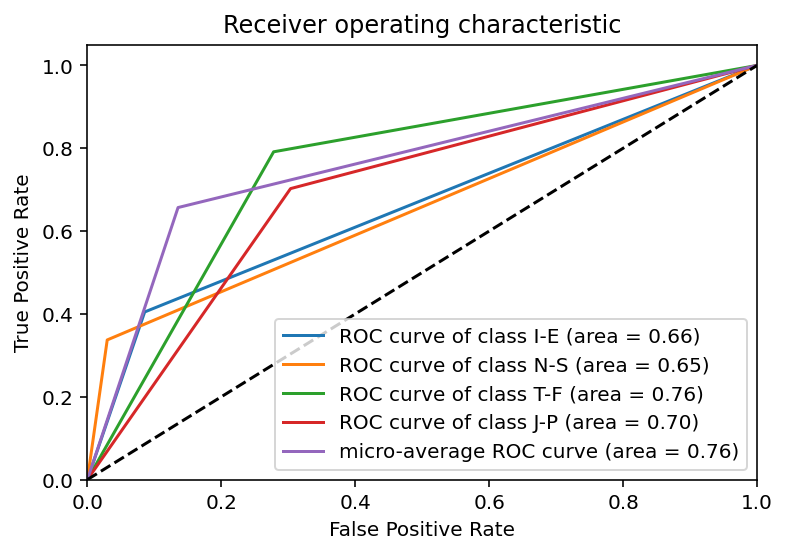

-----------------------------------
evaluating model with test data


  0%|          | 0/1735 [00:00<?, ?it/s]

total mbti hits: 783
total accuracy mbti hits: 45.12968299711815
              precision    recall  f1-score   support

         I-E       0.64      0.43      0.51       397
         N-S       0.55      0.36      0.43       235
         T-F       0.81      0.81      0.81       973
         J-P       0.76      0.70      0.73      1030

   micro avg       0.75      0.67      0.71      2635
   macro avg       0.69      0.57      0.62      2635
weighted avg       0.74      0.67      0.70      2635
 samples avg       0.63      0.60      0.59      2635



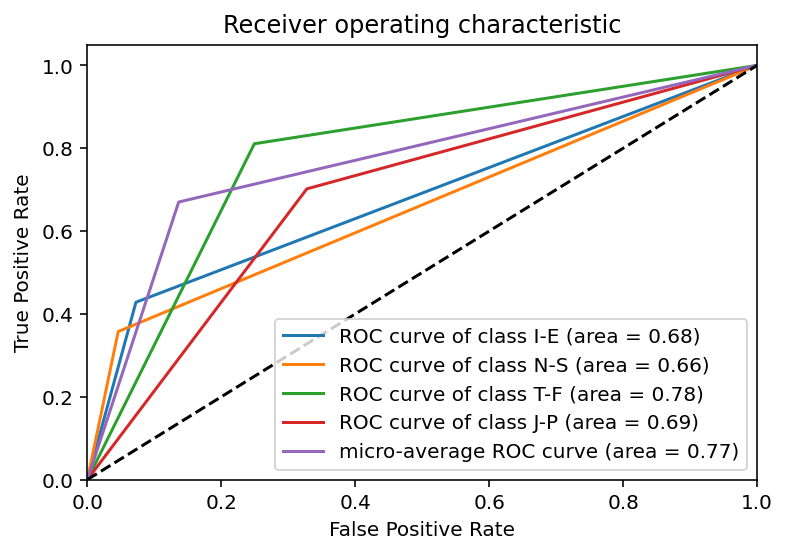

In [ ]:
# load trained model
trained_model = torch.load(PATH)
trained_model.eval()
trained_model.freeze()
print(f"evaluating model with validation data")
evaluate(trained_model, val_df, tokenizer)
print("-----------------------------------")
print(f"evaluating model with test data")
evaluate(trained_model, test_df, tokenizer)

# Data Analysis -
Applying the model on Dating app profiles

## Load Bert Model

In [17]:
trained_model = torch.load(PATH)
trained_model.to(device)

MBTIPersonalityTagger(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

## Preprocess dating profiles data

In [18]:
def clean_bio_column(df):
  # convert to lower
  df['bio'] = df['bio'].str.lower()
  # remove nan
  df['bio'] = df['bio'].str.replace('nan', '')
  for i in tqdm(range(len(df))):
    df_row = df.iloc[i]
    locations = df_row['location'].split(',') + ['san francisco', 'bay area']
    for location in locations:
      df.at[i, 'bio'].replace(location,'')
  df['bio'] = df['bio'].apply(html2text).apply(clean_post)
  return df

In [43]:
# Read the data
DATING_DATA_DIRECTORY = '/drive/MyDrive/Colab Notebooks/NLPFinalProject/profiles.csv'
df = pd.read_csv(DATING_DATA_DIRECTORY)
to_drop = list(['body_type', 'diet', 'drinks', 'drugs', 'ethnicity', 'height', 'job', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9', 'last_online', 'location','offspring', 'orientation', 'pets','religion', 'sign', 'smokes', 'speaks', 'status'])
# join all the essays to one colum
cols = [col for col in df.columns if col.startswith("essay")]
df['bio'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df = clean_bio_column(df)
# drop the unecsseray cols
df.drop(columns=to_drop , inplace=True)
df = df[df['bio'].str.len()>2]
df.head()

  0%|          | 0/59946 [00:00<?, ?it/s]

,age,education,income,sex,bio
0,22,working on college/university,-1,m,would love think some kind intellectual either the dumbest smart guy smartest dumb guy ca n't say tell the difference love to talk about idea concept forge odd metaphor instead of reciting cliche like the simularities friend of mine's house and underwater salt mine favorite word salt the way weird choice know to me thing life better metaphor seek to make little better everyday in some productively lazy way got tired of tying my shoe considered hiring five year old would probably have to tie ...
1,35,working on space camp,80000,m,chef mean am workaholic love cook regardless whether am work love to drink eat food that probably really bad love around people that resemble line love outdoors and am avid skier snowing tahoe at the least am very confident and friendly i 'm interested in acting being typical guy time or patience for rediculous act of territorial pissing overall am very likable easygoing individual am very adventurous and always looking forward to new thing and hopefully sharing the right person dedicating e...
2,38,graduated from masters program,-1,m,i 'm ashamed much writing public text online dating site make pleasantly uncomfortable i 'll try earnest a possible in the noble endeavor of standing naked world i 've lived san francisco year love and find myself frustrated deficit lot of great friend and acquaintance which increase apprehension to put anything on site but i 'm feeling like meeting new people friend of friend okay you are friend of friend chance if make it the complex filtering process of multiple choice question lifestyle ...
3,23,working on college/university,20000,m,"work library go school reading thing written old dead people playing synthesizer and organizing book according to library of congress classification system socially awkward best bataille , celine beckett lynch jarmusch r.w fassbender twin peak fishing john joy division throbbing gristle cabaret voltaire vegetarian pho and coffee cat and german philosophy feel inclined ."
4,29,graduated from college/university,-1,m,hey how 's going currently vague profile know come soon . looking to meet new folk outside circle of friend i 'm pretty responsive on the reply tip feel free to drop line cheer work work work work play creating imagery to look smile lot my inquisitive nature music : band rapper musician at the moment thee oh see forever wu-tang book artbooks day audiobooks my collection thick thanks audible show live one food stellar friend whenever movie tv podcast radiolab american life the moth joe rogan ...


### common words in Bios

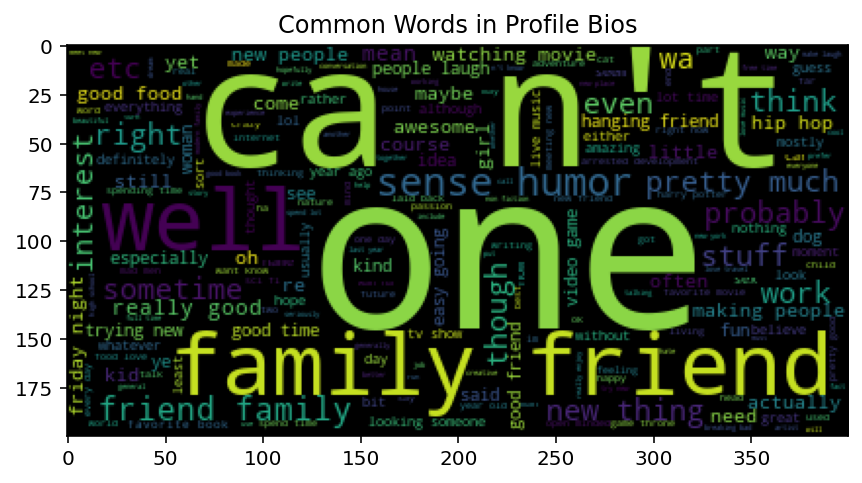

In [ ]:
from wordcloud import WordCloud
# creating word clouds for each of the 16 personality types bios

wordcloud = WordCloud().generate(' '.join(df['bio']))
plt.figure(figsize=(7, 7))
plt.title('Common Words in Profile Bios')
plt.imshow(wordcloud)

# Applying the model

In [44]:
THRESHOLD = 0.5
def assign_labels_to_row(y_pred, row_index, df):
  # assign mbti
  df.at[row_index, "MBTI_type"] = create_mbti_from_vector(y_pred)
  label_to_type = [MAP[i][y_pred[i]] for i in range(len(MAP))]
  for i, label in enumerate(LABEL_COLUMNS):
    df.at[row_index, label] = label_to_type[i]

def apply_model_on_df(df, text_column, trained_model, tokenizer):
  trained_model.eval()
  trained_model.freeze()
  # add the relevant columns to df
  for p in LABEL_COLUMNS+["MBTI_type"]:
    df[p] = ""
  # for each row in the dataframe, run the trained model
  for i in tqdm(range(len(df))):
    data_row = df.iloc[i]
    bio = data_row[text_column]
    # first encode the bio to fit bert specifications
    encoding = tokenizer.encode_plus(
      bio,
      add_special_tokens=True,
      max_length=512,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True)
    # run the trained model on the bio to predict mbti
    _, test_prediction = trained_model(encoding["input_ids"].to(device), encoding["attention_mask"].to(device))
    predictions = test_prediction.detach().cpu().numpy()
    y_pred = np.where(predictions  > THRESHOLD, 1, 0)[0]
    assign_labels_to_row(y_pred, i, df)

In [45]:
apply_model_on_df(df, "bio", trained_model, tokenizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


  0%|          | 0/57797 [00:00<?, ?it/s]

# Analysis

In [48]:
df.head()

,age,education,income,sex,bio,I-E,N-S,T-F,J-P,MBTI_type
0,22.0,working on college/university,-1.0,m,would love think some kind intellectual either the dumbest smart guy smartest dumb guy ca n't say tell the difference love to talk about idea concept forge odd metaphor instead of reciting cliche like the simularities friend of mine's house and underwater salt mine favorite word salt the way weird choice know to me thing life better metaphor seek to make little better everyday in some productively lazy way got tired of tying my shoe considered hiring five year old would probably have to tie ...,I,N,T,P,INTP
1,35.0,working on space camp,80000.0,m,chef mean am workaholic love cook regardless whether am work love to drink eat food that probably really bad love around people that resemble line love outdoors and am avid skier snowing tahoe at the least am very confident and friendly i 'm interested in acting being typical guy time or patience for rediculous act of territorial pissing overall am very likable easygoing individual am very adventurous and always looking forward to new thing and hopefully sharing the right person dedicating e...,I,N,F,P,INFP
2,38.0,graduated from masters program,-1.0,m,i 'm ashamed much writing public text online dating site make pleasantly uncomfortable i 'll try earnest a possible in the noble endeavor of standing naked world i 've lived san francisco year love and find myself frustrated deficit lot of great friend and acquaintance which increase apprehension to put anything on site but i 'm feeling like meeting new people friend of friend okay you are friend of friend chance if make it the complex filtering process of multiple choice question lifestyle ...,I,N,T,J,INTJ
3,23.0,working on college/university,20000.0,m,"work library go school reading thing written old dead people playing synthesizer and organizing book according to library of congress classification system socially awkward best bataille , celine beckett lynch jarmusch r.w fassbender twin peak fishing john joy division throbbing gristle cabaret voltaire vegetarian pho and coffee cat and german philosophy feel inclined .",I,N,T,P,INTP
4,29.0,graduated from college/university,-1.0,m,hey how 's going currently vague profile know come soon . looking to meet new folk outside circle of friend i 'm pretty responsive on the reply tip feel free to drop line cheer work work work work play creating imagery to look smile lot my inquisitive nature music : band rapper musician at the moment thee oh see forever wu-tang book artbooks day audiobooks my collection thick thanks audible show live one food stellar friend whenever movie tv podcast radiolab american life the moth joe rogan ...,I,N,F,J,INFJ


## MBTI Distributions in dating apps profile

In [166]:
df['MBTI_type'].value_counts()

INFP    11728
INTP     9553
INFJ     7707
ISTP     6746
INTJ     5848
ISFJ     3631
ESFP     3275
ISFP     3190
ISTJ     1321
ENFP     1133
ENTP      607
ENFJ      276
ENTJ      198
ESTP      150
ESFJ       65
ESTJ       34
Name: MBTI_type, dtype: int64

[Text(0.5, 1.0, 'Distribution of Personality Types in the Dating app profiles data')]

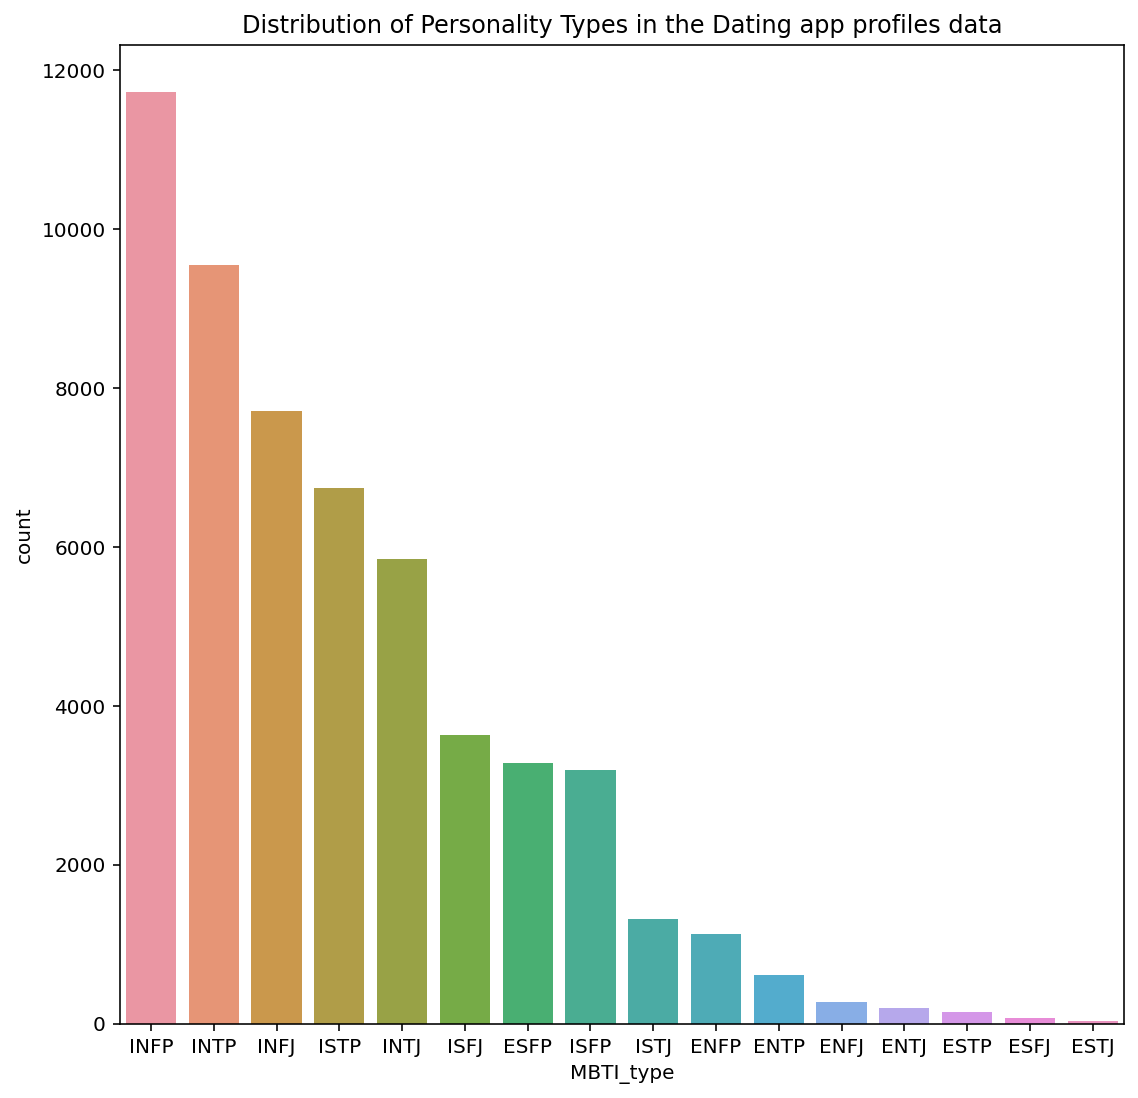

In [165]:
plt.figure(figsize=(9, 9))
#sns.barplot(y=df.MBTI_type.value_counts().index, x=df.MBTI_type.value_counts(), data=df)
sns.countplot(data=df,x='MBTI_type', order = df['MBTI_type'].value_counts().index).set(title='Distribution of Personality Types in the Dating app profiles data')

## Distribution across 4 MBTI axes

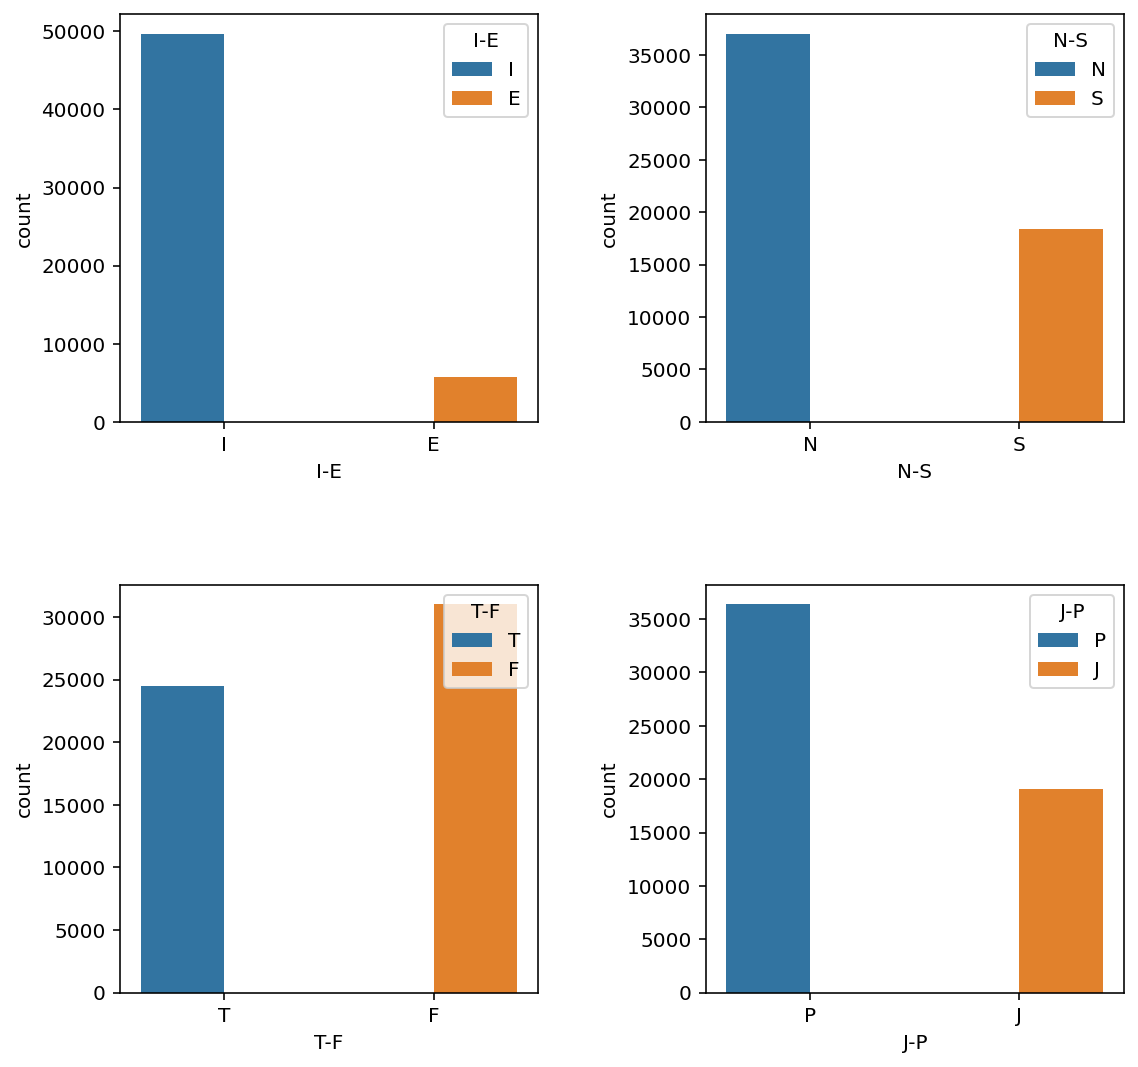

In [167]:
from numpy.ma.core import count
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = ax.ravel()
for i, label in enumerate(LABEL_COLUMNS):
  sns.countplot(data=df,x=label,hue=label, ax=ax[i])

### Gender and MBTI axes

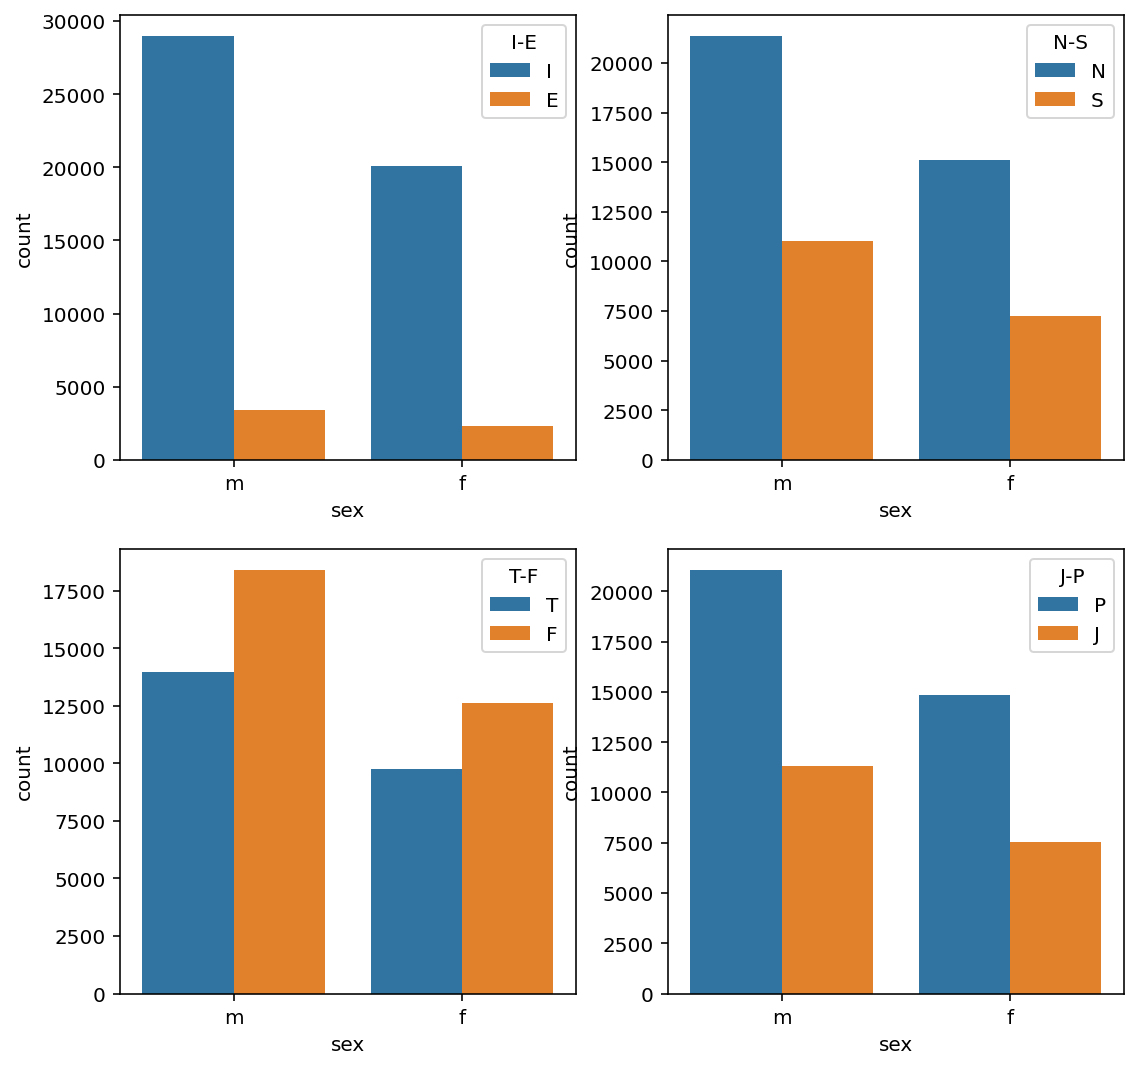

In [164]:
from numpy.ma.core import count
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = ax.ravel()
for i, label in enumerate(LABEL_COLUMNS):
  sns.countplot(data=df,x='sex',hue=label, ax=ax[i])

##correlation between income and MBTI types

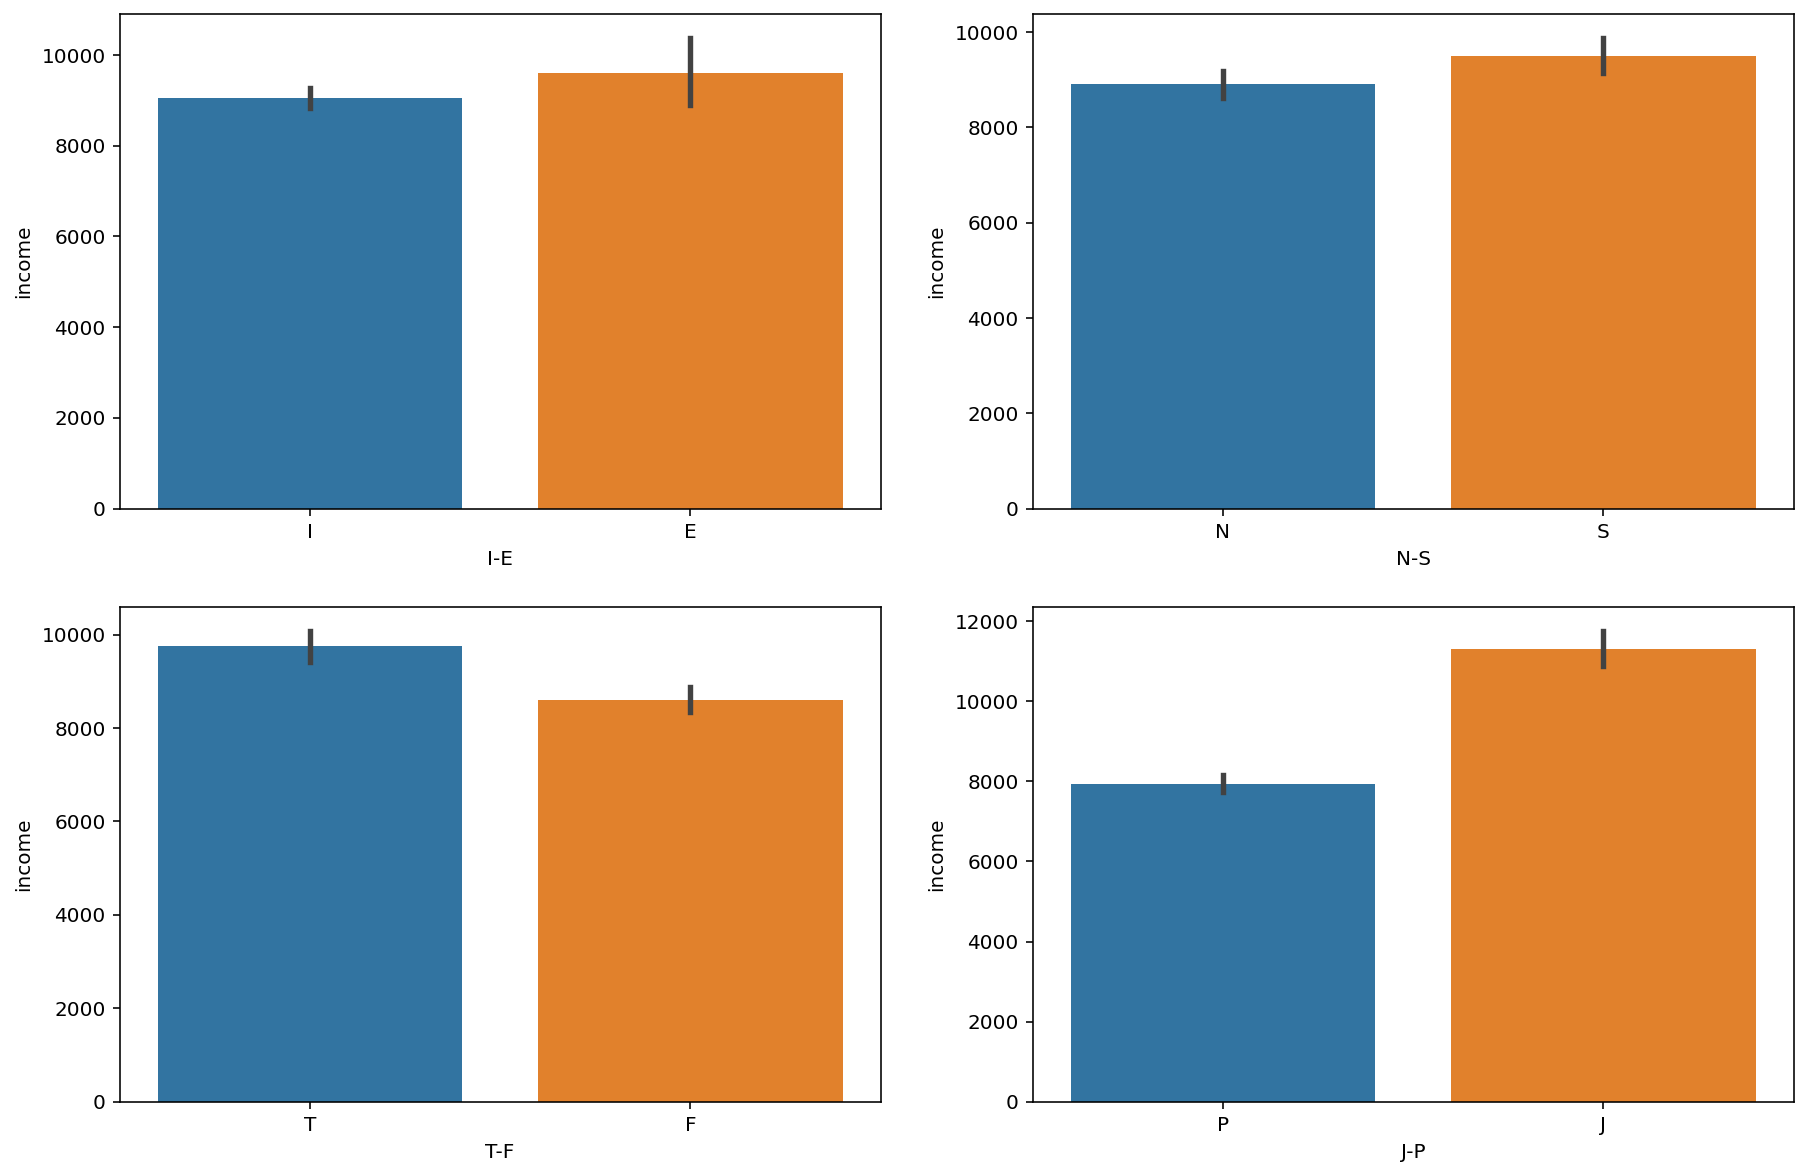

In [168]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = ax.ravel()
for i, label in enumerate(LABEL_COLUMNS):
  sns.barplot(x=label, y='income', data=df, estimator=np.mean,ax=ax[i])